# Setup

중요: 로컬 머신에서 실행 중인 경우 [설치 지침](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md)을 따르세요. 이 노트북에는 Colab에서 실행하는 데 필요한 것만 포함되어 있습니다.

저장소의 상위 디렉토리에 `tensorflow/models` 또는 `cd`를 가져옵니다.

### Imports

In [1]:
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
import zipfile

print(np.__version__)

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
from xml.etree.ElementTree import Element, SubElement, ElementTree

1.22.4


개체 감지 모듈을 가져옵니다.

In [2]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

패치:

In [3]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# 모델 준비

## 변수

`export_inference_graph.py` 도구를 사용하여 내보낸 모든 모델은 경로를 변경하기만 하면 여기에서 로드할 수 있습니다.

기본적으로 여기에서는 "Mobilenet이 있는 SSD" 모델을 사용합니다. 외부에서 실행할 수 있는 다른 모델 목록은 [검출 모델 동물원](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)을 참조하세요. 다양한 속도와 정확도를 가진 상자.

## Loader

In [4]:
def local_load_model(model_dir):
  # base_url = 'http://download.tensorflow.org/models/object_detection/'
  # model_file = model_name + '.tar.gz'
  # model_dir = tf.keras.utils.get_file(
  #   fname=model_name, 
  #   origin=base_url + model_file,
  #   untar=True)

  # model_dir = pathlib.Path(model_dir)/"saved_model"
  model = tf.saved_model.load(str(model_dir))

  return model

## 라벨 맵 로드 중
레이블은 인덱스를 범주 이름에 매핑하므로 컨볼루션 네트워크가 '5'를 예측할 때 이것이 '비행기'에 해당한다는 것을 알 수 있습니다. 여기서 내부 유틸리티 함수를 사용하지만 정수를 적절한 문자열 레이블에 매핑하는 사전을 반환하는 모든 것이 좋습니다.

In [5]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'annotations/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

간단하게 하기 위해 2개의 이미지에 대해 테스트합니다.

In [6]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
import pathlib

PATH_TO_TEST_IMAGES_DIR = pathlib.Path('test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('test_images/10_114B_GA1_평면도 기본형_photoinfra_1466659552567.jpg'),
 WindowsPath('test_images/10_240_GA1_평면도 기본형_photoinfra_1624245363884.jpg'),
 WindowsPath('test_images/13_293_GA1_평면도 기본형_412_13974_13_293_GA1_1292393292088.jpg'),
 WindowsPath('test_images/14_276_GA2_평면도 대칭형_412_13124_14_207_GA2_1280381402588.jpg'),
 WindowsPath('test_images/14_67_GA1_평면도 기본형_GW70262_1316506718317.jpg'),
 WindowsPath('test_images/14_77B_GA1_평면도 기본형_GW70833_1319446358525.jpg'),
 WindowsPath('test_images/7_117_GA1_평면도 기본형_NB10639_1336197309465.jpg'),
 WindowsPath('test_images/7_123B_GA1_평면도 기본형_photoinfra_1466416142660.jpg'),
 WindowsPath('test_images/7_126_GA1_평면도 기본형_GW70711_1331110871245.jpg'),
 WindowsPath('test_images/7_134_GA1_평면도 기본형_412_12615_7_134_GA1_1292392988983.jpg'),
 WindowsPath('test_images/7_153_GA1_평면도 기본형_GW70711_1330074672164.jpg'),
 WindowsPath('test_images/7_269_GA1_평면도 기본형_GW70711_1332232051759.jpg'),
 WindowsPath('test_images/8_201_GA1_평면도 기본형_412_12418_8_198_1276741848

# 탐지

객체 감지 모델 로드:

In [7]:
model_dir = "exported-models/my_faster_rcnn_model/saved_model/"
detection_model = local_load_model(model_dir)

모델의 입력 서명을 확인하면 uint8 유형의 3색 이미지 배치가 필요합니다.

In [8]:
detection_model.signatures['serving_default'].output_dtypes

{'raw_detection_boxes': tf.float32,
 'detection_anchor_indices': tf.float32,
 'detection_boxes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'raw_detection_scores': tf.float32,
 'detection_classes': tf.float32}

In [9]:
detection_model.signatures['serving_default'].output_shapes

{'raw_detection_boxes': TensorShape([1, 300, 4]),
 'detection_anchor_indices': TensorShape([1, 300]),
 'detection_boxes': TensorShape([1, 300, 4]),
 'detection_scores': TensorShape([1, 300]),
 'num_detections': TensorShape([1]),
 'detection_multiclass_scores': TensorShape([1, 300, 87]),
 'raw_detection_scores': TensorShape([1, 300, 87]),
 'detection_classes': TensorShape([1, 300])}

Add a wrapper function to call the model, and cleanup the outputs:

In [10]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # 입력은 텐서여야 하며 `tf.convert_to_tensor`를 사용하여 변환합니다.
  input_tensor = tf.convert_to_tensor(image)
  # 모델은 이미지 배치를 예상하므로 `tf.newaxis`를 사용하여 축을 추가합니다.
  input_tensor = input_tensor[tf.newaxis,...]

  # 추론 (inference) 실행
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # 모든 출력은 배치 텐서입니다.
  # numpy 배열로 변환하고 인덱스 [0]을 사용하여 배치 차원을 제거합니다.
  # 우리는 첫 번째 num_detections에만 관심이 있습니다.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes는 정수여야 합니다.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # 마스크가 있는 모델 처리:
  if 'detection_masks' in output_dict:
    # bbox 마스크를 이미지 크기로 재구성합니다.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

  return output_dict

xml 가독성

In [11]:
def _pretty_print(current, parent=None, index=-1, depth=0):
    for i, node in enumerate(current):
        _pretty_print(node, current, i, depth + 1)
    if parent is not None:
        if index == 0:
            parent.text = '\n' + ('\t' * depth)
        else:
            parent[index - 1].tail = '\n' + ('\t' * depth)
        if index == len(parent) - 1:
            current.tail = '\n' + ('\t' * (depth - 1))

각 테스트 이미지에서 라벨링에 필요한 xml 추출

In [12]:
def export(model, image_path):
  # 이미지의 배열 기반 표현은 나중에 준비하기 위해 사용됩니다. 상자와 레이블이 있는 결과 이미지입니다.
  image_np = np.array(Image.open(image_path))
  # 실제 감지.
  output_dict = run_inference_for_single_image(model, image_np)

  height, width, _ = image_np.shape
  obj_index = output_dict['detection_scores'] > 0.5
  boxes = output_dict['detection_boxes'][obj_index]
  classes = output_dict['detection_classes'][obj_index]
  
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      max_boxes_to_draw=1000,
      min_score_thresh=.5,
      line_thickness=3)

  display(Image.fromarray(image_np))

  root = Element("annotation")
  ele_folder = Element("folder")
  ele_folder.text = str(PATH_TO_TEST_IMAGES_DIR)
  root.append(ele_folder)

  ele_filename = Element("filename")
  ele_filename.text = str(image_path.name)
  root.append(ele_filename)

  ele_path = Element("path")
  ele_path.text = str(pathlib.Path(image_path).resolve())
  root.append(ele_path)

  ele_source = Element("source")
  root.append(ele_source)

  sub_ele_database = SubElement(ele_source, "database")
  sub_ele_database.text = "Unknown"

  ele_size = Element("size")
  root.append(ele_size)

  sub_ele_width = SubElement(ele_size, "width")
  sub_ele_width.text = str(width)

  sub_ele_height = SubElement(ele_size, "height")
  sub_ele_height.text = str(height)

  sub_ele_depth = SubElement(ele_size, "depth")
  sub_ele_depth.text = "depth"

  ele_segmented = Element("segmented")
  ele_segmented.text = "0"
  root.append(ele_segmented)

  for box, cls in zip(boxes, classes):
    ele_object = Element("object")
    root.append(ele_object)

    sub_ele_name = SubElement(ele_object, "name")
    sub_ele_name.text = category_index[cls]['name']

    sub_ele_pose = SubElement(ele_object, "pose")
    sub_ele_pose.text = "Unspecified"

    sub_ele_truncated = SubElement(ele_object, "truncated")
    sub_ele_truncated.text = "0"

    sub_ele_difficult = SubElement(ele_object, "difficult")
    sub_ele_difficult.text = "0"

    sub_ele_bndbox = Element("bndbox")
    ele_object.append(sub_ele_bndbox)

    sub_ele_bndbox_xmin = SubElement(sub_ele_bndbox, "xmin")
    sub_ele_bndbox_xmin.text = str(int(box[1] * width))

    sub_ele_bndbox_ymin = SubElement(sub_ele_bndbox, "ymin")
    sub_ele_bndbox_ymin.text = str(int(box[0] * height))

    sub_ele_bndbox_xmax = SubElement(sub_ele_bndbox, "xmax")
    sub_ele_bndbox_xmax.text = str(int(box[3] * width))

    sub_ele_bndbox_ymax = SubElement(sub_ele_bndbox, "ymax")
    sub_ele_bndbox_ymax.text = str(int(box[2] * height))

  _pretty_print(root)
  
  tree = ElementTree(root)

  with open("./test_images/" + image_path.stem + ".xml", 'wb') as outfile:
    tree.write(outfile, encoding='utf-8')

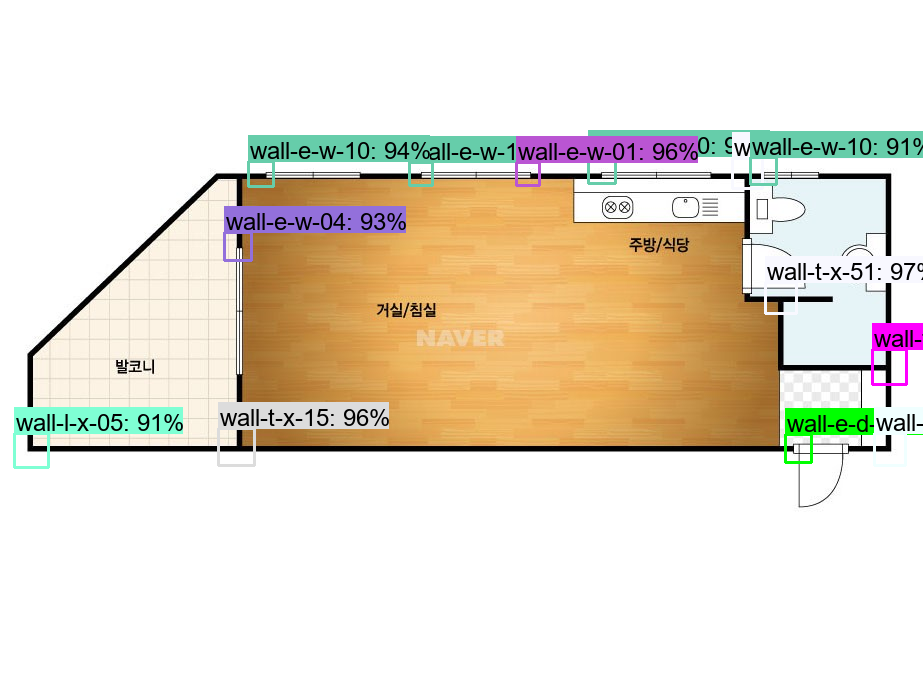

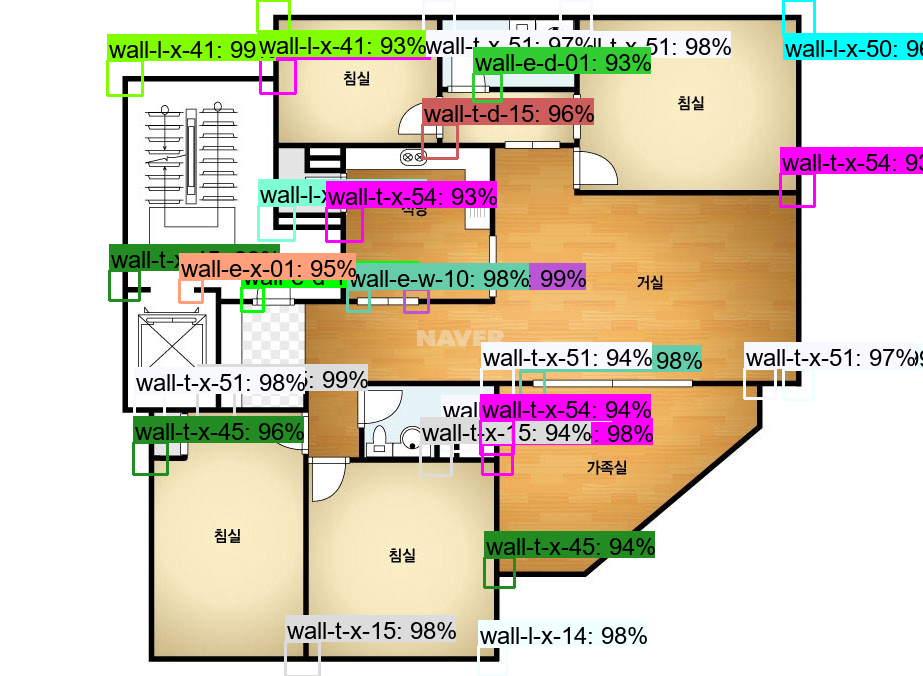

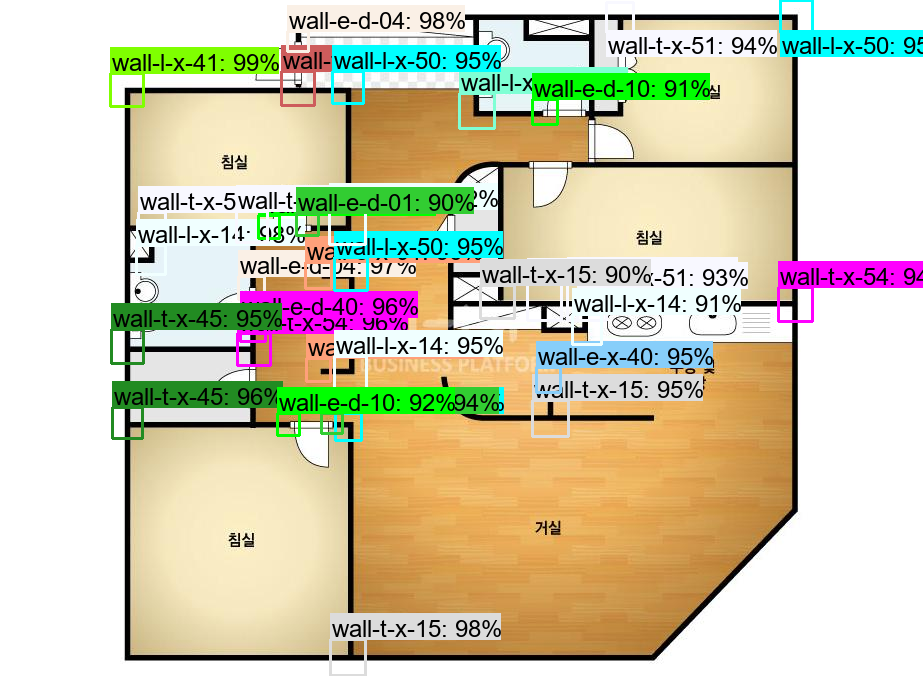

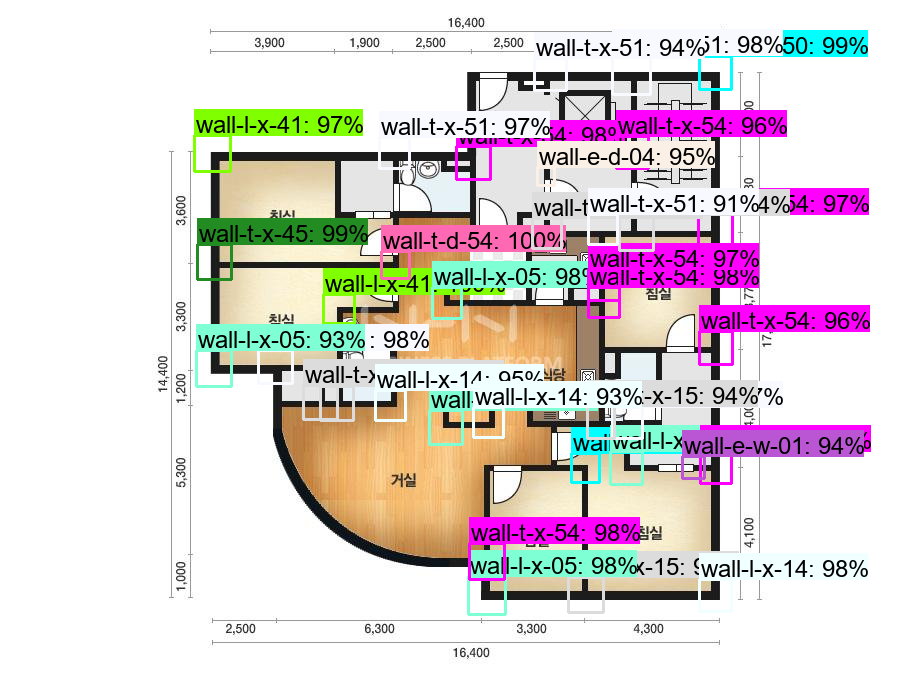

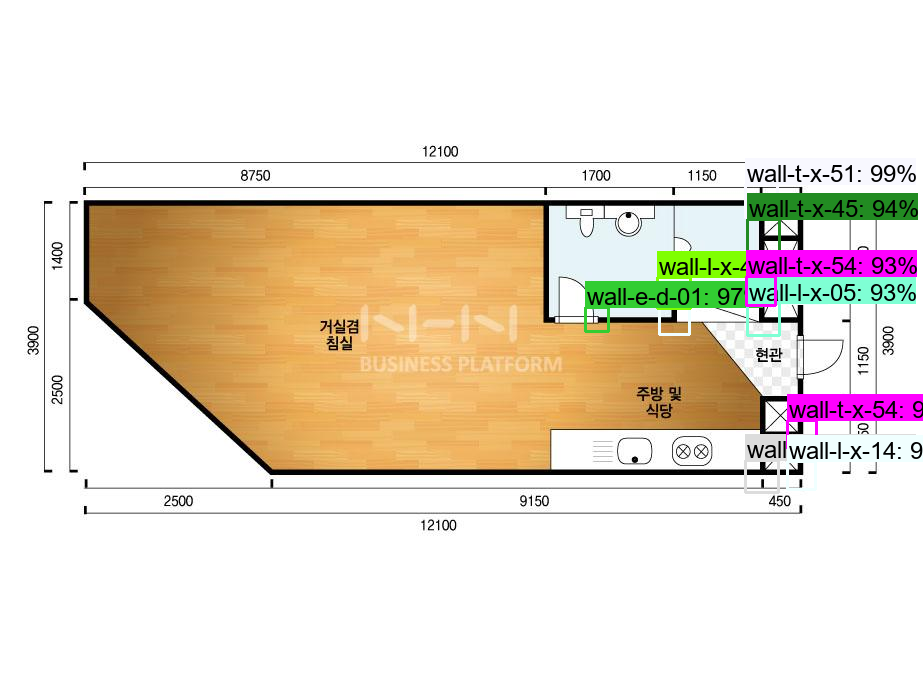

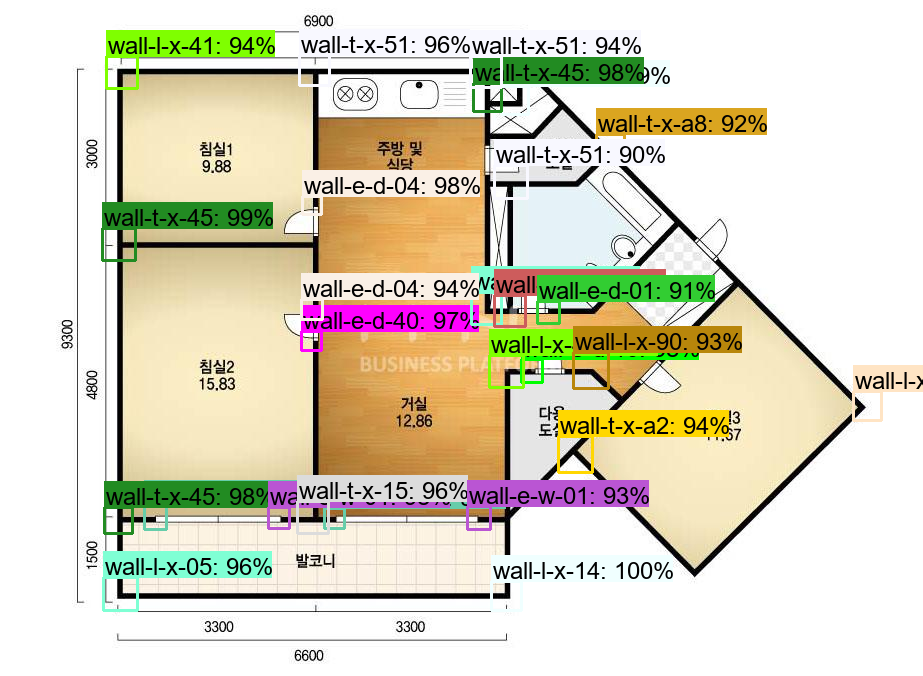

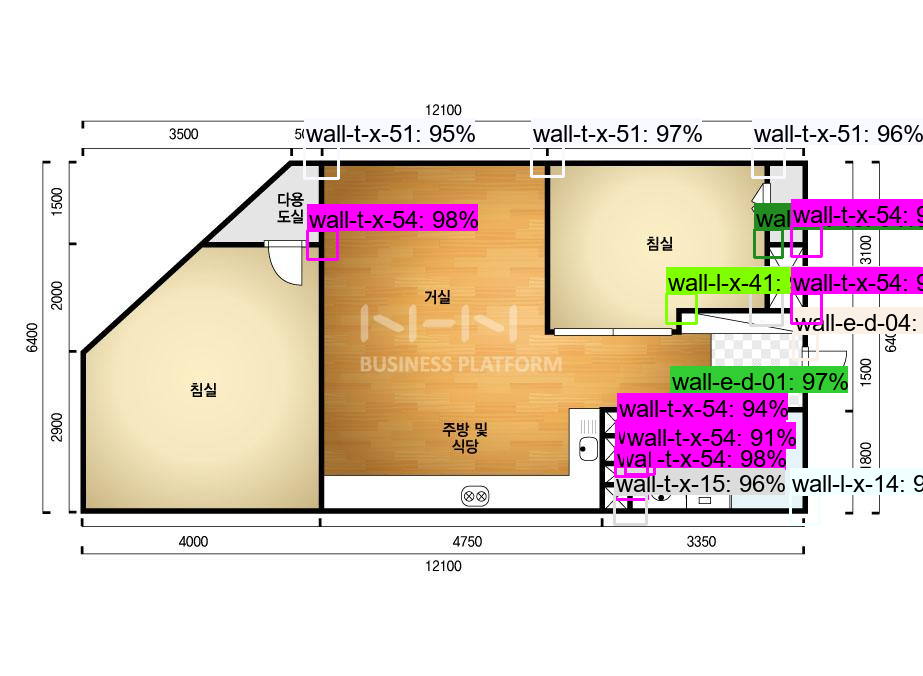

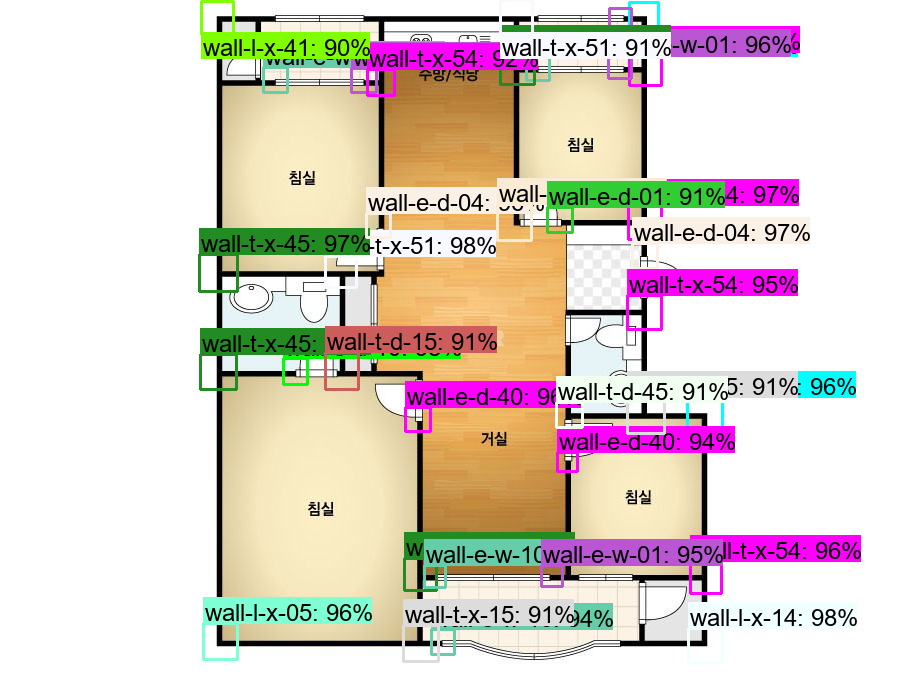

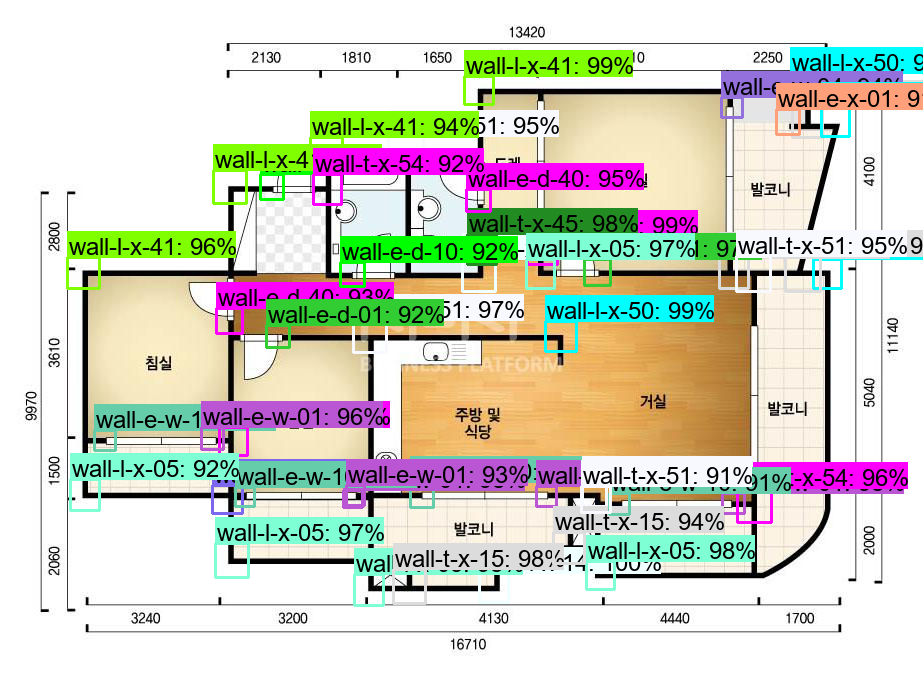

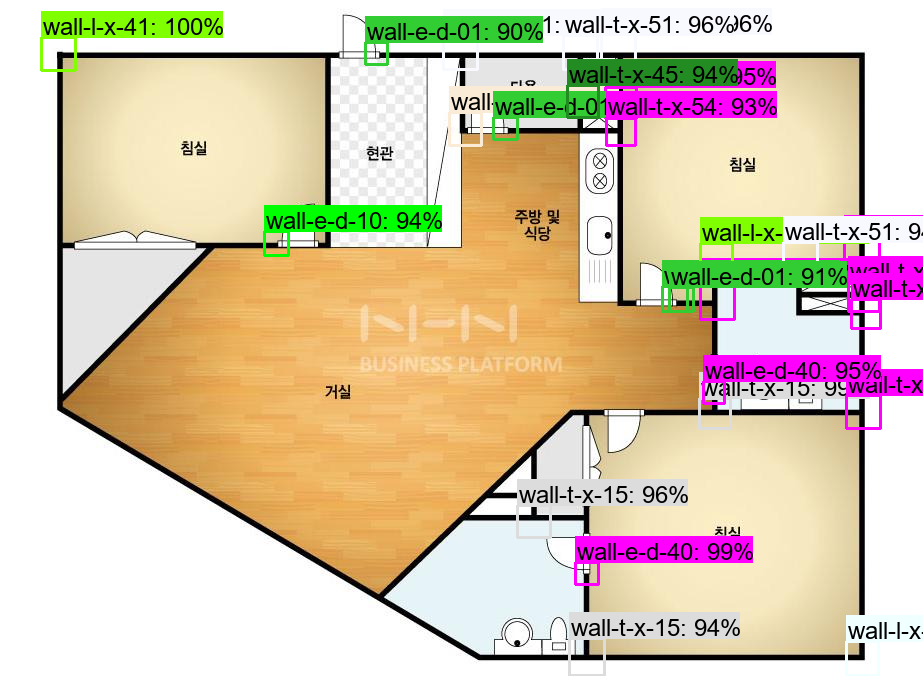

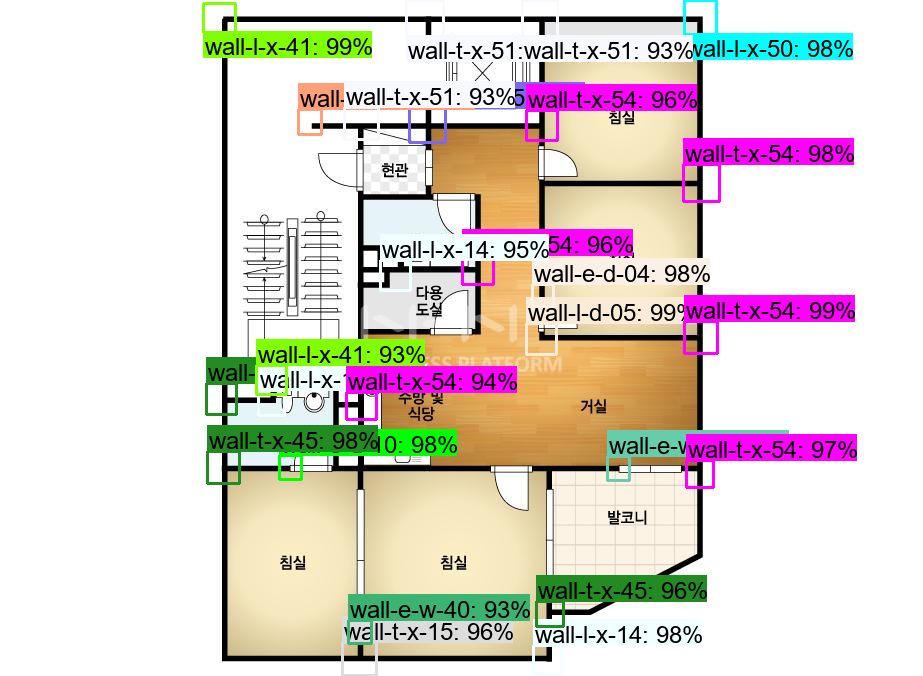

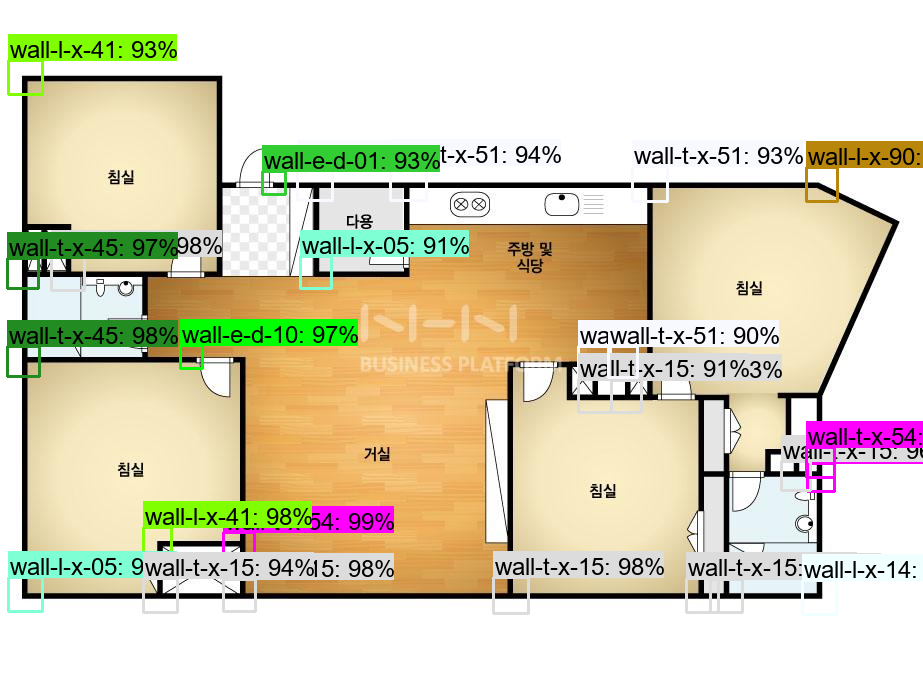

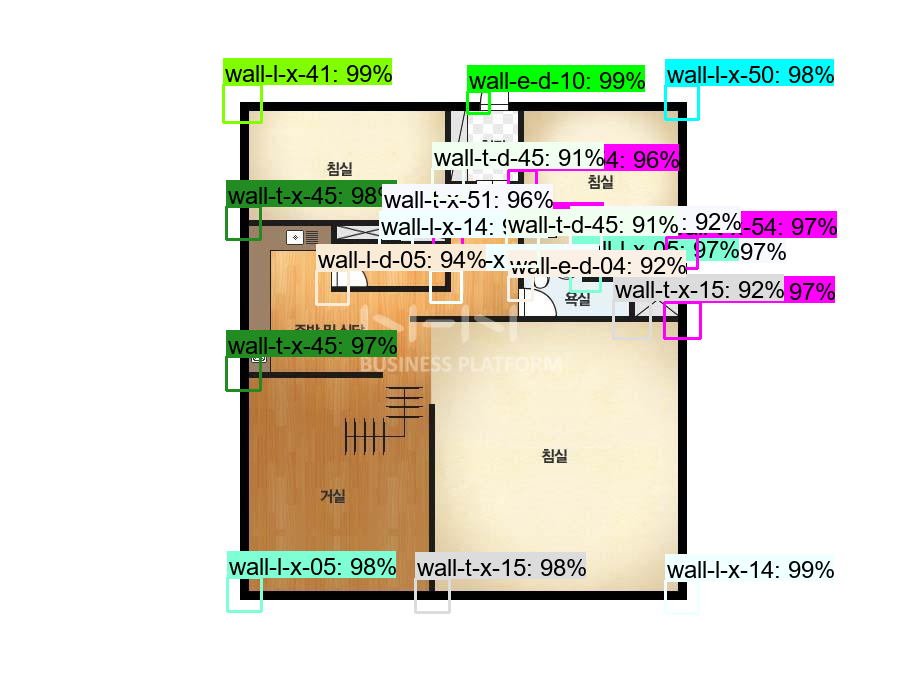

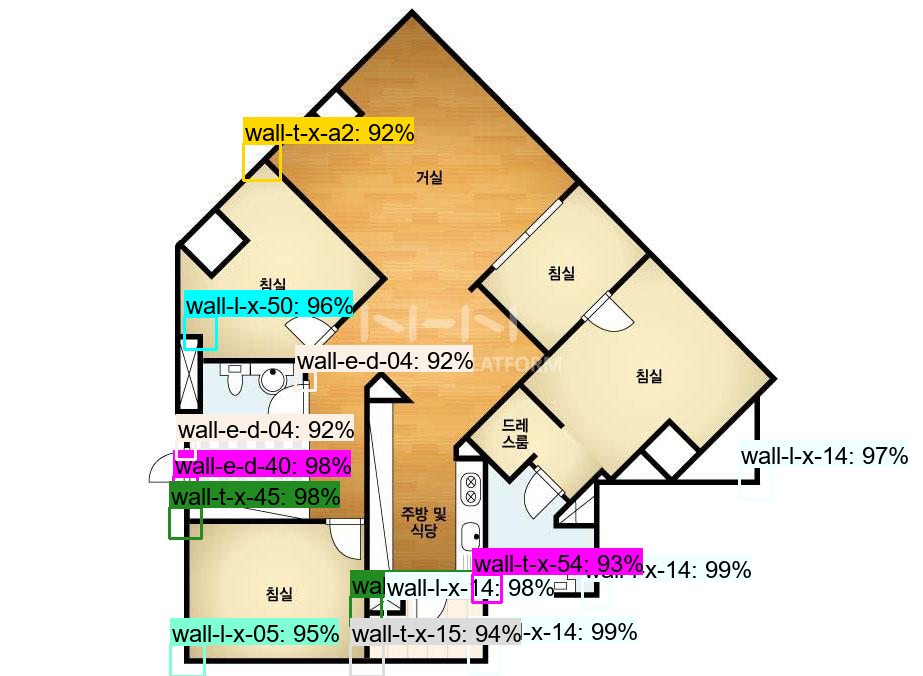

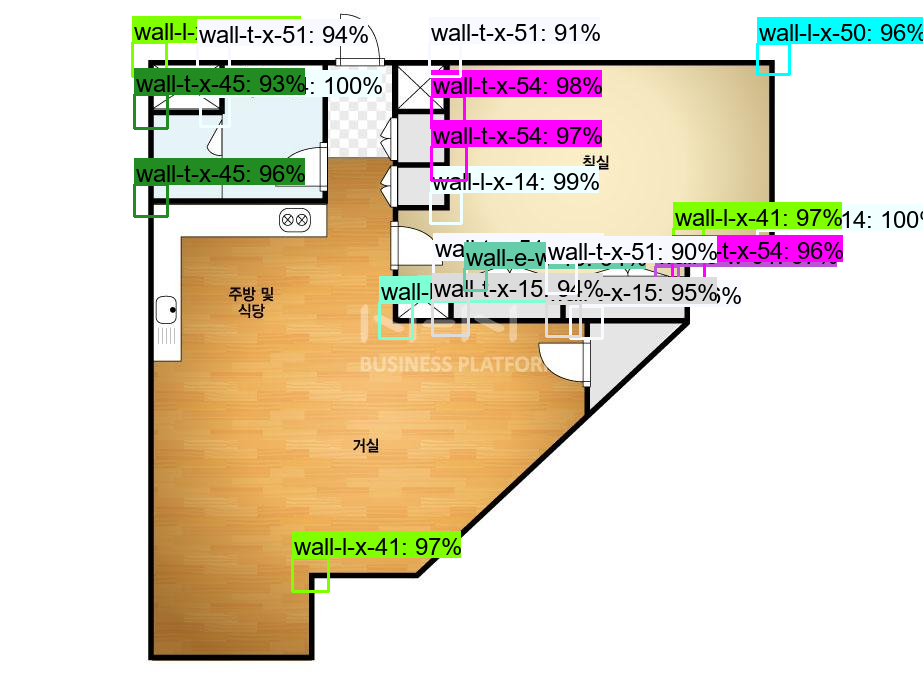

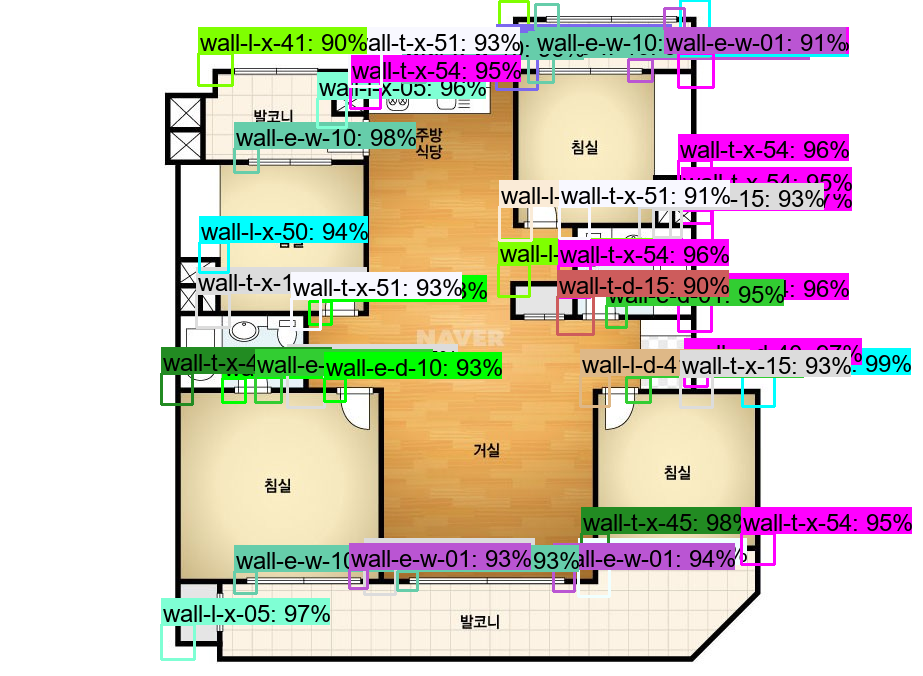

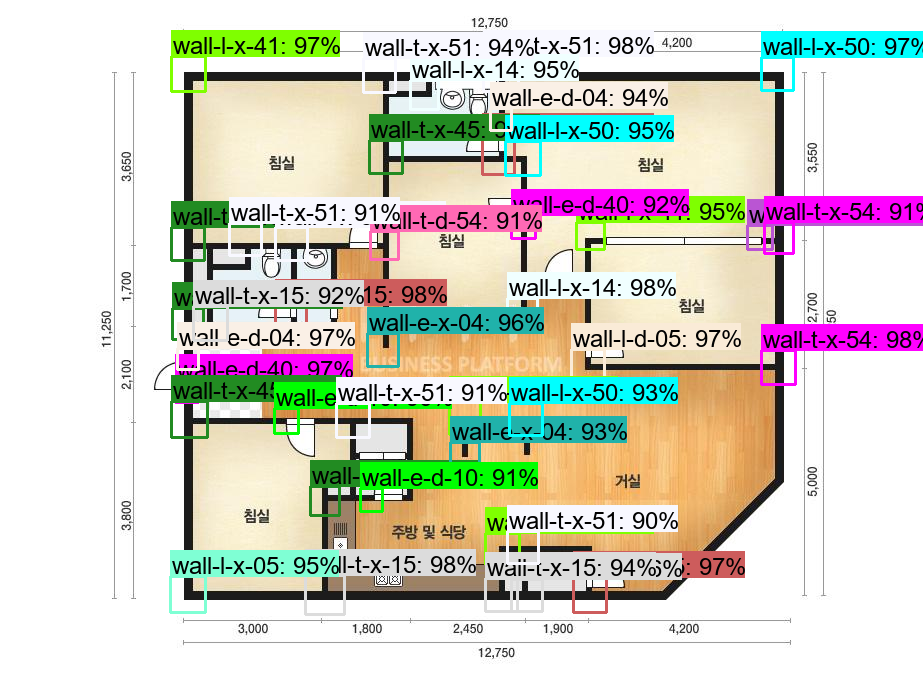

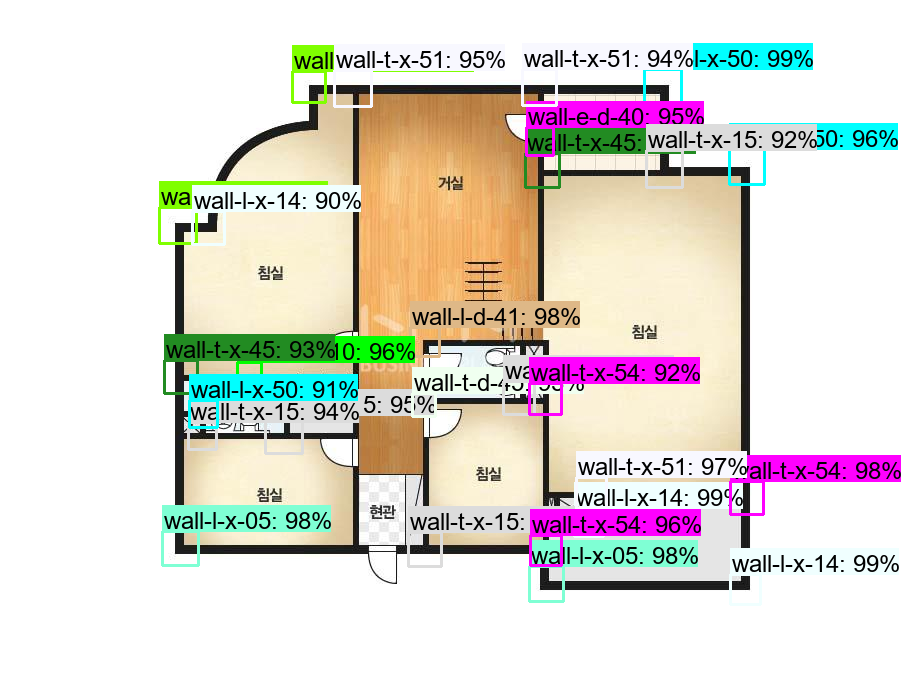

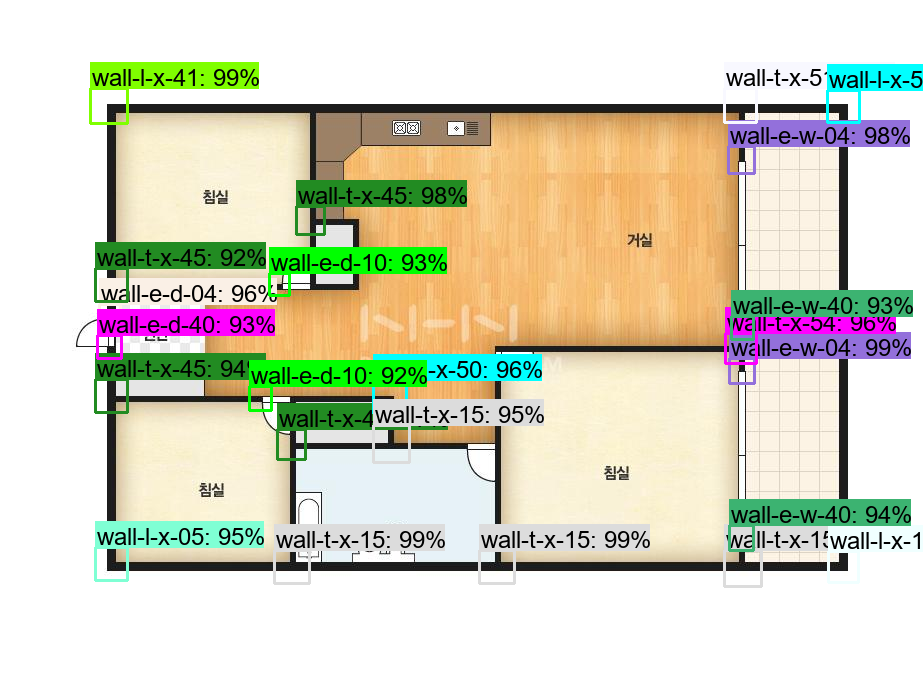

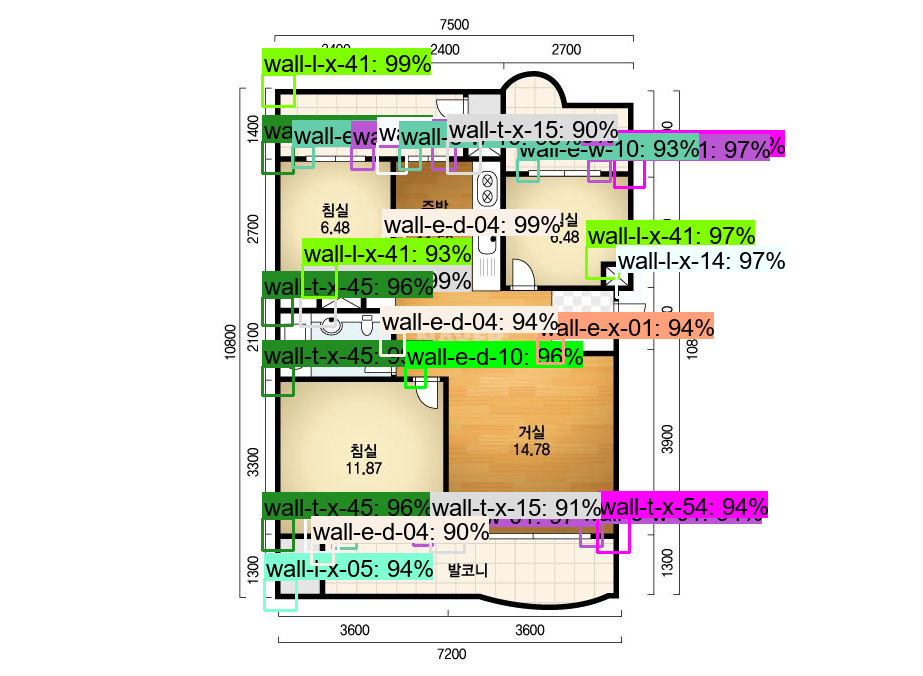

In [13]:
for image_path in TEST_IMAGE_PATHS:
  export(detection_model, image_path)